In [1]:
!pip install scipy matplotlib scikit-learn tqdm ortools -U

Requirement already up-to-date: scipy in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages
Requirement already up-to-date: matplotlib in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages
Requirement already up-to-date: scikit-learn in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages
Requirement already up-to-date: tqdm in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages
Requirement already up-to-date: ortools in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages
Requirement already up-to-date: numpy>=1.13.3 in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages (from scipy)
Requirement already up-to-date: kiwisolver>=1.0.1 in /Users/nmurzin/.pyenv/versions/3.6.3/envs/diversityhack/lib/python3.6/site-packages (from matplotlib)
Requirement already up-to-date: cycler>=0.10 in /Users/nmurzi

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [176]:
data = json.load(open('phystech/data/hard_input.json'))
couriers = data['couriers']
depots = data['depots']
orders = data['orders']

In [177]:
# courier initial time windows
for i, courier in enumerate(couriers):
    courier['from'] = 6 * 60
    courier['to'] = 24 * 60

In [178]:
depots = []

In [179]:
# Manhattan
def manhattan_distance(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

In [180]:
impossible_orders = 0
filtered_orders = []
for order in orders:
    distance = manhattan_distance(order['pickup_location_x'], order['pickup_location_y'], 
                                  order['dropoff_location_x'], order['dropoff_location_y'])
    
    closest_courier = None
    closest_courier_distance = np.inf
    for courier in couriers:
        courier_distance = manhattan_distance(courier['location_x'], courier['location_y'], 
                                              order['pickup_location_x'], order['pickup_location_y'])
        
        if courier_distance < closest_courier_distance:
            closest_courier = courier
            closest_courier_distance = courier_distance
    
    max_window = order['dropoff_to'] - max(order['pickup_from'], 360 + closest_courier_distance)
    
    if distance >= max_window:
        impossible_orders += 1
    else:
        filtered_orders.append(order)
        
print(f"Total orders: {len(orders)}, Impossible without depot: {impossible_orders}")

Total orders: 5, Impossible without depot: 0


In [181]:
orders = filtered_orders

In [182]:
# fix order's time windows
bad_order_counter = 0
for order in orders:
    if order['pickup_to'] <= order['pickup_from']:
        order['pickup_to'], order['pickup_from'] = order['pickup_from'], order['pickup_to']
        bad_order_counter += 1
        print(order['pickup_from'], order['pickup_to'])
        
    if order['dropoff_to'] <= order['dropoff_from']:
        order['dropoff_to'], order['dropoff_from'] = order['dropoff_from'], order['dropoff_to']
        bad_order_counter += 1
        print(order['dropoff_from'], order['dropoff_to'])
bad_order_counter

0

In [183]:
payments = [order['payment'] for order in orders]

In [184]:
np.mean(payments), np.std(payments)

(900.0, 0.0)

(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([899.5, 899.6, 899.7, 899.8, 899.9, 900. , 900.1, 900.2, 900.3,
        900.4, 900.5]),
 <a list of 10 Patch objects>)

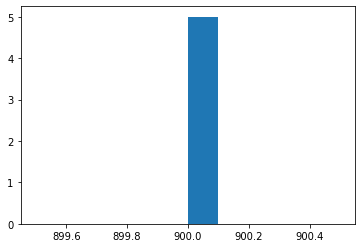

In [185]:
plt.hist(payments)

In [186]:
len(couriers), len(depots), len(orders)

(5, 0, 5)

In [187]:
depot_positions = []
for depot in depots:
    depot_positions.append([depot['location_x'], depot['location_y']])
    
courier_positions = []
for courier in couriers:
    courier_positions.append([courier['location_x'], courier['location_y']])

In [188]:
min(order['pickup_location_y'] for order in orders)

30

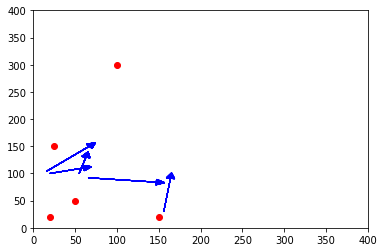

In [189]:
plt.xlim(0, 400)
plt.ylim(0, 400)
for order in np.random.choice(orders, 100):
    a_x, a_y = order['pickup_location_x'], order['pickup_location_y']
    b_x, b_y = order['dropoff_location_x'], order['dropoff_location_y']
    plt.arrow(a_x, a_y, b_x - a_x, b_y - a_y, head_width=10, head_length=10, color='blue')
    
plt.scatter(*np.transpose(courier_positions), c='red')
if depot_positions:
    plt.scatter(*np.transpose(depot_positions), c='black')                  
plt.show()

## Clusterization

In [190]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics

In [191]:
import pdb

min_radius = 12
max_radius = 42
min_no_clusters = 50
max_avg_cluster_size = 500
max_cluster_size = 500

def recursive_dbscan(X, indices, min_radius, max_radius):
    best_clusters = None
    best_cluster_size = 0
    while min_radius < max_radius:
        curr_radius = (min_radius + max_radius) / 2

        clusters = DBSCAN(eps=curr_radius, metric='cityblock').fit(X)
        no_clusters = len(np.unique(clusters))
        
        if no_clusters < min_no_clusters: # not enough clusters
            max_radius = curr_radius - 1
        else:
            min_radius = curr_radius + 1
            
        avg_cluster_size = np.histogram(clusters.labels_)[0].mean()

        if avg_cluster_size > best_cluster_size: # choose the biggest cluster possible
            best_cluster_size = avg_cluster_size
            best_clusters = clusters

    if best_clusters is None:
        return [indices]
    
    final_idx = [np.where(best_clusters.labels_ == i)[0] for i in np.unique(best_clusters.labels_)]
    final_indices = [indices[i] for i in final_idx]
    final_clusters = [X[i] for i in final_idx]
    new_clusters = []
    for cluster_indices, cluster in zip(final_indices, final_clusters):
        if len(cluster) > max_cluster_size:
            new_clusters.extend(recursive_dbscan(cluster, cluster_indices, 0.9999 * max_radius, 1.2 * max_radius))
        else:
            new_clusters.append(cluster_indices)
    return new_clusters

In [192]:
X = np.array([[order['pickup_location_x'], order['pickup_location_y']] for order in orders])

In [193]:
clusters = recursive_dbscan(X, np.arange(len(X)), min_radius, max_radius)

In [194]:
clusters = sorted(clusters, key=len)

In [195]:
np.sort([len(c) for c in clusters])

array([5])

In [196]:
labels = np.zeros(len(X))
for label, cluster in enumerate(clusters):
    for idx in cluster:
        labels[idx] = label

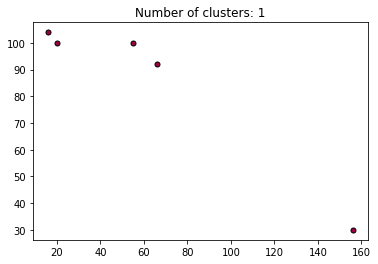

In [197]:
n_clusters_ = len(clusters)

# #############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

## OR Tools

In [198]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [199]:
from scipy.spatial.distance import pdist, cdist
from collections import defaultdict

class ORToolsSolver:

    def __init__(self, couriers, orders, depots):
        
        self.couriers = couriers
        self.orders = orders
        self.depots = depots
        
        courier_positions = [[courier['location_x'], courier['location_y']] for courier in couriers]
        pickup_positions = [[order['pickup_location_x'], order['pickup_location_y']] for order in orders]
        dropoff_positions = [[order['dropoff_location_x'], order['dropoff_location_y']] for order in orders]
        depot_positions = [[depot['location_x'], depot['location_y']] for depot in depots]
        
        self.courier_id_to_node = {courier['courier_id']: idx + 1 for idx, courier in enumerate(couriers)}
        self.pickup_id_to_node = {order['pickup_point_id']: idx + 1 + len(couriers) for idx, order in enumerate(orders)}
        self.dropoff_id_to_node = {order['dropoff_point_id']: idx + 1 + len(couriers) + len(orders) for idx, 
                                   order in enumerate(orders)}
        self.depot_id_to_node = {depot['point_id']: idx + 1 + len(couriers) + 2 * len(orders) for idx, depot in enumerate(depots)}

        all_positions = courier_positions + pickup_positions + dropoff_positions + depot_positions

        dist_matrix = cdist(all_positions, all_positions, 'cityblock')
        all_payments = - 0.5 * np.tile([0] * len(courier_positions) + [0] * len(pickup_positions) + 
                                       [0] * len(depot_positions) + payments, (len(all_positions), 1))
        payment_shift = all_payments.min()
#         dist_payment_matrix = dist_matrix + all_payments
#         dist_payment_matrix = dist_payment_matrix - payment_shift
#         dist_payment_matrix[np.diag_indices(dist_payment_matrix.shape[0])] = 0
        
        self.dist_matrix = np.pad(dist_matrix, ((1, 0), (1, 0)), mode='constant')
#         self.dist_payment_matrix = np.pad(dist_payment_matrix, ((1, 0), (1, 0)), mode='constant')
        
        # Create the routing index manager.
        self.manager = pywrapcp.RoutingIndexManager(len(self.dist_matrix), len(couriers), 
                                                    list(range(1, len(couriers) + 1)), 
                                                    [0] * len(couriers))

        # Create Routing Model.
        self.routing = pywrapcp.RoutingModel(self.manager)
        
        time_transit_callback_index = self.routing.RegisterTransitCallback(self.time_callback)

        cost_transit_callback_index = self.routing.RegisterTransitCallback(self.time_callback)
        self.routing.SetArcCostEvaluatorOfAllVehicles(cost_transit_callback_index)
        
        # Add Distance constraint.
        self.routing.AddDimension(
            time_transit_callback_index,
            24 * 60,  # courier max wait time
            24 * 60,  # courier maximum travel time
            False,
            'Distance')

        time_dimension = self.routing.GetDimensionOrDie('Distance')
        time_dimension.SetGlobalSpanCostCoefficient(1)

        # cost is 2 times the distance
        cost_dimension = self.routing.GetDimensionOrDie('Distance')
        cost_dimension.SetGlobalSpanCostCoefficient(2)
        
        # Add time window constraints for each pickups and dropoffs
        for order in orders:
            pickup_index = self.manager.NodeToIndex(self.order_to_pickup_node(order))
            dropoff_index = self.manager.NodeToIndex(self.order_to_dropoff_node(order))
            time_dimension.CumulVar(pickup_index).SetRange(order['pickup_from'], order['pickup_to'])
            time_dimension.CumulVar(dropoff_index).SetRange(order['dropoff_from'], order['dropoff_to'])

        # Courier time window
        for courier_index, courier in enumerate(self.couriers):
            index = self.routing.Start(courier_index)
            time_dimension.CumulVar(index).SetRange(courier['from'], courier['to'])
        
        for i in range(len(couriers)):
            self.routing.AddVariableMinimizedByFinalizer(
                cost_dimension.CumulVar(self.routing.Start(i)))
            self.routing.AddVariableMinimizedByFinalizer(
                cost_dimension.CumulVar(self.routing.End(i)))
        
        # Define Transportation Requests.
        for order in orders:
            pickup_index = self.manager.NodeToIndex(self.order_to_pickup_node(order))
            dropoff_index = self.manager.NodeToIndex(self.order_to_dropoff_node(order))

            self.routing.AddPickupAndDelivery(pickup_index, dropoff_index)

            self.routing.solver().Add(self.routing.VehicleVar(pickup_index) == self.routing.VehicleVar(dropoff_index))

            # pickup before dropoff
            self.routing.solver().Add(time_dimension.CumulVar(pickup_index) <= time_dimension.CumulVar(dropoff_index))
            
        # Allow to ignore orders, penalty
        for order in orders:
            self.routing.AddDisjunction([self.manager.NodeToIndex(self.order_to_pickup_node(order))],  order['payment'] // 2)
            self.routing.AddDisjunction([self.manager.NodeToIndex(self.order_to_dropoff_node(order))], order['payment'] // 2)
            
    def order_to_pickup_node(self, order):
        return self.pickup_id_to_node[order['pickup_point_id']]

    def order_to_dropoff_node(self, order):
        return self.dropoff_id_to_node[order['dropoff_point_id']]

    def depot_to_node(self, depot):
        return self.depot_id_to_node[depot['point_id']]

    def courier_to_node(self, courier):
        return self.courier_id_to_node[courier['courier_id']]
        
    def time_callback(self, from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        dist = self.dist_matrix[self.manager.IndexToNode(from_index), self.manager.IndexToNode(to_index)]
        
        if to_index != 0:
            dist += 10
        
        return dist
        
#     def cost_callback(self, from_index, to_index):
#         """Returns the manhattan distance between the two nodes."""
#         # Convert from routing variable Index to distance matrix NodeIndex.
#         return self.dist_payment_matrix[self.manager.IndexToNode(from_index)][self.manager.IndexToNode(to_index)]
    
    def solve(self):
        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.solution_limit = 1
#         search_parameters.time_limit.seconds = 180
#         search_parameters.lns_time_limit.seconds = 1
        search_parameters.savings_parallel_routes = True

        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC)

        # Solve the problem.
        assignment = self.routing.SolveWithParameters(search_parameters)
        return assignment
    
    def is_dropoff_node(self, node):
        return node > 1 + len(self.couriers) + len(self.orders)
    
    def get_routes(self, assignment, verbose=False):
        """Get routes from assignment."""
        total_distance = 0
        total_dropped = 0
        courier_routes = defaultdict(lambda: [])
        courier_distance = []
        for courier_index in range(len(self.couriers)):
            index = self.routing.Start(courier_index)
            courier_routes[courier_index].append(index)
            plan_output = 'Route for courier {}:\n'.format(courier_index)
            route_distance = 0
            while not self.routing.IsEnd(index):
    
                plan_output += ' {} -> '.format(self.manager.IndexToNode(index))
                previous_index = index
                index = assignment.Value(self.routing.NextVar(previous_index))
                courier_routes[courier_index].append(index)
                
                route_distance += self.routing.GetArcCostForVehicle(
                    previous_index, index, courier_index)
                
                if self.is_dropoff_node(self.manager.IndexToNode(index)):
                    total_dropped += 1
    #             if previous_index > len(couriers) + 1 and index > len(couriers) + 1:
    #                 route_cost += payment_shift
    #         route_cost *= 2 
    
            courier_distance.append(route_distance)
            plan_output += '{}\n'.format(self.manager.IndexToNode(index))
            plan_output += 'Cost of the route: {}m\n'.format(route_distance)
            if verbose and previous_index != self.routing.Start(courier_index):
                print(plan_output)
            total_distance += route_distance
        if verbose:
            print('Total Cost of all routes: {}m, Fractions of orders dropped off: {}'.format(
                total_distance, total_dropped / len(self.orders)))
        return {courier: {'route': route[:-1], 'time': distance} 
                for (courier, route), distance in zip(courier_routes.items(), courier_distance) if len(route) > 2}
    

In [200]:
def get_node_action(courier, node, orders):
    n = len(orders)
    point_id = 'pickup_point_id' if node < n else 'dropoff_point_id'
    action = 'pickup' if node < n else 'dropoff'
    node = node if node < n else node - n
    return {'courier_id': courier['courier_id'], 'action': action, 
            'order_id': orders[node]['order_id'], 'point_id': orders[node][point_id]}

In [201]:
from tqdm import tqdm
import copy

solution = []

temp_couriers = copy.deepcopy(couriers)
clusters_copy = copy.deepcopy(clusters)

for cluster in tqdm(np.random.permutation(clusters_copy)):

    cluster_orders = [orders[i] for i in cluster]
    solver = ORToolsSolver(couriers, cluster_orders, depots)
    assignment = solver.solve()
    try:
        cluster_routes = solver.get_routes(assignment)

        # update courier time window and starting node according to last destination
        for courier_node, courier_info in cluster_routes.items():
            temp_couriers[courier_node]['from'] += courier_info['time']

            end_node = courier_info['route'][-1] - len(temp_couriers)
            end_node = end_node if end_node < len(cluster_orders) else end_node - len(cluster_orders)

            temp_couriers[courier_node]['location_x'] = orders[cluster[end_node]]['dropoff_location_x']
            temp_couriers[courier_node]['location_y'] = orders[cluster[end_node]]['dropoff_location_y']

        cluster_solution = [get_node_action(temp_couriers[courier_node], node - len(temp_couriers), cluster_orders) 
                            for courier_node, info in cluster_routes.items() for node in info['route'][1:]
                           ]

        solution.extend(cluster_solution)
    except:
        print(cluster)
        pass

100%|██████████| 1/1 [00:00<00:00, 89.94it/s]


In [202]:
len(solution)

10

In [203]:
courier_info

{'route': [2, 9, 14], 'time': 115}

In [204]:
cluster_routes

{1: {'route': [1, 7, 5, 6, 10, 11, 12, 8, 13], 'time': 431},
 2: {'route': [2, 9, 14], 'time': 115}}

In [205]:
cluster

array([0, 1, 2, 3, 4])

In [128]:
[node - 300 for node in cluster_routes[181]['route'][1:]]

[5, 6, 3, 10, 1, 8, 12, 13]

In [124]:
clusters[10]

array([1885, 3157, 3995, 4330, 6236])

In [41]:
temp_couriers[140 - 1]

{'courier_id': 140,
 'location_x': 63,
 'location_y': 50,
 'from': 546,
 'to': 1440}

In [42]:
orders[cluster[end_node]]

{'order_id': 12660,
 'pickup_point_id': 42660,
 'pickup_from': 330,
 'pickup_to': 720,
 'pickup_location_x': 322,
 'pickup_location_y': 61,
 'dropoff_point_id': 62660,
 'dropoff_from': 780,
 'dropoff_to': 840,
 'dropoff_location_x': 63,
 'dropoff_location_y': 50,
 'payment': 679}

In [206]:
json.dump(solution, open('solution_hard.json', 'w'))